## autoencoder model

In [0]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

import random

# custom dataloader for .npy file
class numpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]

        if self.transform:
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.data)


class Autoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # encoder layers
        self.conv1 = nn.Conv2d(1, 256, 3, padding=1)  
        self.conv2 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 16, 3, padding=1)

        # pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.t_conv1 = nn.ConvTranspose2d(16, 128, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(128, 256, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(256, 1, 2, stride=2)

       

    def forward(self, x):
        # encode
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x) 
        x = F.relu(self.conv3(x))
        x = self.pool(x) 
        
        # decode
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.sigmoid(self.t_conv3(x))
                
        return x

generate_data = True

model = Autoencoder()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.03)
objective = nn.MSELoss(reduction='sum')

## train method

In [0]:
def train(batch_idx, epoch, image, target):
    data, target = Variable(image).cuda(), Variable(target).cuda()

    optimizer.zero_grad()
    
    output = model(target)
    loss = objective(output, data)

    loss.backward()
    optimizer.step()

    loss_t = loss.item() / len(data)

    return loss_t

## training

In [6]:
NUM_EPOCH = 70

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

traindata = np.load('/content/drive/My Drive/Colab Notebooks/train.npy')
traindataset = numpyDataset(traindata, transform)
trainloader = DataLoader(traindataset, batch_size=4, shuffle=True, drop_last=True, num_workers=2)

loss_mean, loss_std = [], []

model.train()
for epoch in range(NUM_EPOCH):

    batch_t = []

    for batch_idx, data in enumerate(trainloader):

        # Noisy Images #
        i = random.randint(1, 4) * 0.01
        image = data + (i * torch.randn(len(data), 1, 120, 80))

        loss_t = train(batch_idx, epoch, data, image)
        batch_t.append(loss_train)

    loss_mean.append(np.mean(batch_t))
    loss_std.append(np.std(batch_t))

    print("[epoch %s] loss(training): %s" % (epoch, loss_mean[-1]))

[epoch 0] loss(training): 12.205754459337754
[epoch 1] loss(training): 3.787986361438578
[epoch 2] loss(training): 2.991530156352303
[epoch 3] loss(training): 2.6084053585746068
[epoch 4] loss(training): 2.7152962687882507
[epoch 5] loss(training): 2.559706251079386
[epoch 6] loss(training): 2.478726564429023
[epoch 7] loss(training): 2.4144612415270372
[epoch 8] loss(training): 2.366153056946668
[epoch 9] loss(training): 2.339125778024847
[epoch 10] loss(training): 2.2856255971301684
[epoch 11] loss(training): 2.321519608064131
[epoch 12] loss(training): 2.2071657629446553
[epoch 13] loss(training): 2.3280735313892365
[epoch 14] loss(training): 2.1454501383954825
[epoch 15] loss(training): 2.065173200152137
[epoch 16] loss(training): 2.065949364846403
[epoch 17] loss(training): 2.0959901547431947
[epoch 18] loss(training): 2.0060494582219555
[epoch 19] loss(training): 1.985864567648281
[epoch 20] loss(training): 2.0141639935428444
[epoch 21] loss(training): 1.947597713145343
[epoch 22

## run model with test data

In [ ]:
testdata = np.load('/content/drive/My Drive/Colab Notebooks/test.npy')
testdataset = numpyDataset(testdata, transform)
testloader = DataLoader(testdataset, batch_size=1, shuffle=False, drop_last=False, num_workers=2)
model.eval()

result_for_submit = None  # this is for submit file

for batch_idx, data in enumerate(testloader):

    with torch.no_grad():
        result_of_test = model.forward(Variable(data).cuda())

    if batch_idx == 0:
        result_for_submit = result_of_test
    else:
        try:
            result_for_submit = torch.cat([result_for_submit, result_of_test], dim=0)

        except RuntimeError:
            transposed = torch.transpose(result_of_test, 2, 3)
            result_for_submit = torch.cat([result_for_submit, transposed], dim=0)

# the submit_file.shape must be (400,1,120,80)
submit_file = result_for_submit.detach().numpy()
np.save('20154338_ChoiChanghwan.npy', submit_file)

## plot graph

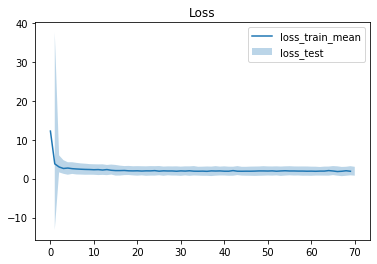

In [9]:
plt.title("Loss") 
plt.plot(loss_train_mean)
plt.fill_between(np.arange(1,len(loss_train_mean)+1), np.array(loss_train_mean) - np.array(loss_train_std),np.array(loss_train_mean) + np.array(loss_train_std), alpha = 0.3) 
plt.legend(['loss_train_mean','loss_test']) 
plt.show()